In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, MiniBatchSparsePCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

In [2]:
df = pd.read_pickle('FT-data-DSpace/data_agreggated.pickle')
df = df[['Date', 'Meeting Number', 'Clean']]

In [3]:
df['Sentences'] = df['Clean'].apply(lambda x: ' '.join(x))
df['Date'] = pd.to_datetime(df['Date'])
df.sample(2)

,Date,Meeting Number,Clean,Sentences
634,2015-05-12 13:00:00,90. møde,"[mød, åbn, så, går, anmeld, beskæftigelsesmini...",mød åbn så går anmeld beskæftigelsesminist hen...
96,2010-05-26 13:00:00,97. møde,"[mød, åbn, dag, enkelt, anmeld, indenr, sundhe...",mød åbn dag enkelt anmeld indenr sundhedsminis...


In [101]:
#tvec = TfidfVectorizer(min_df=.01, max_df=1.0, sublinear_tf=True, analyzer='word', ngram_range=(1,2), max_features=20000)
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=20000)
x = tvec.fit_transform(df['Sentences'])

words = tvec.get_feature_names()

In [102]:
df_x = pd.DataFrame(columns= words, data=x.toarray())
df_x['Date'] = df['Date']
df_x['Year'] = df_x['Date'].dt.year
df_x['Meeting'] = df['Meeting Number']
df_x.sample(2)

,3f,aaen,aaen enhedslist,aaen kort,aaen kort bemærkning,aaja,aaja chemnitz,aaja chemnitz lars,aalborg,aalborg portland,...,øvr henvis,øvr henvis ugeplan,øvr ikk,øvr kan,øvr meg,øvr parti,øvr vær,Date,Year,Meeting
323,0.000696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001560,0.001187,...,0.000581,0.00066,0.001395,0.000000,0.0,0.000581,0.0,2012-10-04 10:00:00,2012,3. møde
416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004258,0.000000,...,0.000000,0.00000,0.002539,0.001705,0.0,0.000000,0.0,2013-05-15 13:00:00,2013,96. møde


### PCA

In [111]:
#pca = MiniBatchSparsePCA(n_components=500,alpha = 1e-3, n_jobs=4, batch_size=15) #normal PCA does not work
pca = KernelPCA(n_components=500, kernel='cosine', alpha=1e-2, fit_inverse_transform=True, max_iter=1000)
pca_result = pca.fit_transform(df_x[words].values)
df_x['pca-one'] = pca_result[:,0]
df_x['pca-two'] = pca_result[:,1] 
df_x['pca-three'] = pca_result[:,2]
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [112]:
k = 4
kmeans = KMeans(n_clusters=k).fit(pca_result)
df_x['label'] = kmeans.labels_

In [113]:
df_x.sample(2)

,3f,aaen,aaen enhedslist,aaen kort,aaen kort bemærkning,aaja,aaja chemnitz,aaja chemnitz lars,aalborg,aalborg portland,...,øvr meg,øvr parti,øvr vær,Date,Year,Meeting,pca-one,pca-two,pca-three,label
130,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002057,0.000868,0.0,2010-11-23 13:00:00,2010,22. møde,0.009975,-0.026897,-0.029765,3
425,0.024571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000976,0.0,2013-05-30 10:00:00,2013,105. møde,-0.082472,-0.138993,0.068899,3


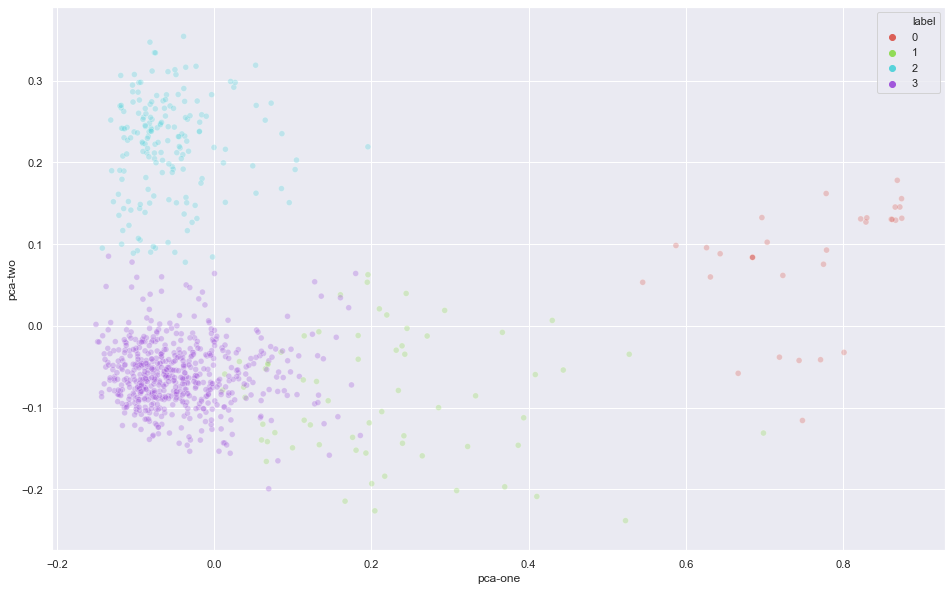

In [114]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

#### T-SNE

In [115]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.068s...
[t-SNE] Computed neighbors for 863 samples in 0.519s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.121159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.077293
[t-SNE] KL divergence after 1000 iterations: 1.679129
t-SNE done! Time elapsed: 4.2725770473480225 seconds


In [116]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

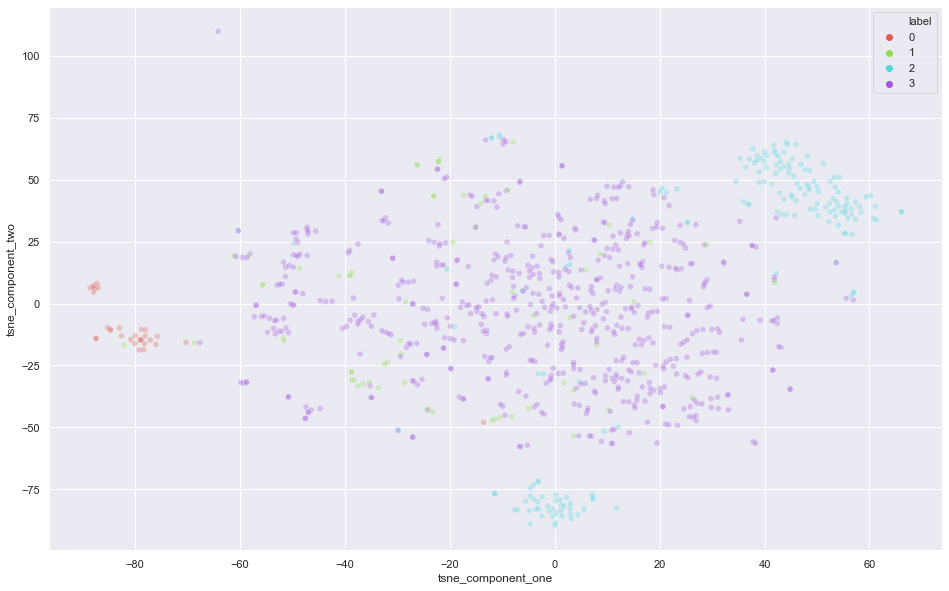

In [117]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

In [ ]:
df_x